In [12]:
import numpy as np
from labs.perceptron import MultilayerPerceptron
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = pd.read_csv('mushrooms.csv', delimiter=',')

X = data.drop('class', axis=1)
y = data['class'].apply(lambda x: np.float64(1) if x == 'p' else np.float64(0))  # Encode 'p' as 1, 'e' as 0

X = pd.get_dummies(X, dtype=np.float64)

X = X.drop('stalk-root_?', axis=1).values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

input_size = X_train.shape[1]
mlp = MultilayerPerceptron(input_size=input_size, hidden_size=5, output_size=1)

mlp.train(X_train, y_train, learning_rate=10e-3, epochs=10)

predictions = mlp.predict(X_test)

print(predictions)

predictions = mlp.predict(X_test) > 0.5

accuracy = accuracy_score(y_test, predictions)

print(f"Train Accuracy: {accuracy_score(y_train, mlp.predict(X_train) > 0.5)}")
print(f"Test Accuracy: {accuracy}")



[[0.99219967]
 [0.99653302]
 [0.        ]
 ...
 [0.        ]
 [0.99786896]
 [0.98618013]]
Train Accuracy: 0.9990767810432374
Test Accuracy: 0.9987692307692307


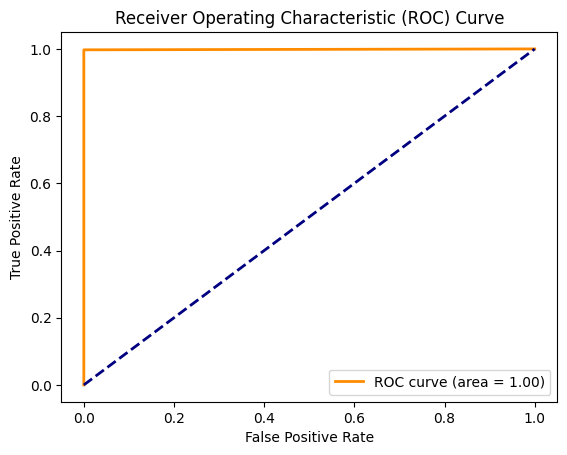

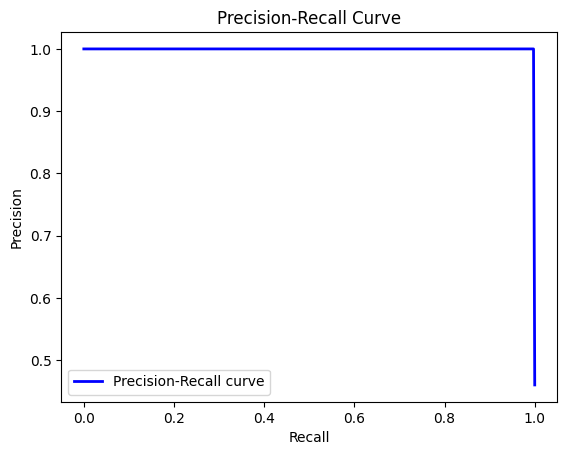

In [14]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, predictions)
# todo F1
# todo clasification report sklearn
# todo скинуть ему гит

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [15]:
import numpy as np

# Self-implemented metrics calculation
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    support = len(y_true) #support - the number of true instances for each label. 
    
    return precision, recall, f1_score, support, accuracy

# Calculate metrics
precision, recall, f1_score, support, accuracy = calculate_metrics(y_test, predictions)

# Print classification metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")
print(f"Support: {support}")
print(f"Accuracy: {accuracy}")

Precision: 1.0
Recall: 0.9973262032085561
F1-Score: 0.998661311914324
Support: 1625
Accuracy: 0.9987692307692307
